# Imports

In [1]:
try:
    from fancyimpute import IterativeSVD
    from fancyimpute import KNN
    print("Library is already installed.")
except ImportError:
    print("Library is not installed. Proceed with installation.")
    !pip install fancyimpute
    from fancyimpute import IterativeSVD
    from fancyimpute import KNN

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from scipy.optimize import minimize
import optuna
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import re

import warnings
warnings.filterwarnings("ignore", category=UserWarning, message="'verbose' argument is deprecated.*")

Library is already installed.


### Path management

In [2]:
base: str
if os.getcwd() == "/kaggle/working":
    base = "/kaggle"
else:
    base = os.path.join(os.getcwd())

def get_full_dir(sub_dir: str) -> str:
    return os.path.join(base, sub_dir)

# EDA

In [3]:
df_sample_submission: pd.DataFrame = pd.read_csv(get_full_dir('input/playground-series-s3e15/sample_submission.csv'))
df_data: pd.DataFrame = pd.read_csv(get_full_dir('input/playground-series-s3e15/data.csv'), index_col='id')
df_train = df_data[~df_data['x_e_out [-]'].isna()]
df_test = df_data[df_data['x_e_out [-]'].isna()]
df_og: pd.DataFrame = pd.read_csv(get_full_dir('input/predicting-heat-flux/Data_CHF_Zhao_2020_ATE.csv'), index_col='id')

In [4]:
def remove_special_characters(column_name):
    return re.sub(r"[^a-zA-Z0-9_]+", "", column_name)

def remove_special_characters_from_dataframe(df):
    df.columns = [remove_special_characters(col) for col in df.columns]
    return df

In [5]:
df_data = remove_special_characters_from_dataframe(df_data)
df_train = remove_special_characters_from_dataframe(df_train)
df_test = remove_special_characters_from_dataframe(df_test)
df_og = remove_special_characters_from_dataframe(df_og)

In [6]:
train = pd.DataFrame(df_train.isna().sum() * 100 / df_train.count())
train['dataset'] = 'train'

test = pd.DataFrame(df_test.isna().sum() * 100 / df_test.count())
test['dataset'] = 'test'

og = pd.DataFrame(df_og.isna().sum() * 100 / df_og.count())
og['dataset'] = 'original'

df_tmp = pd.concat([train, test, og], axis=0)
df_tmp = df_tmp.replace(np.inf, 100)
df_tmp = df_tmp.rename(columns={0: 'NaN Percentage %', 'dataset': 'Data Set'})
df_tmp['Column'] = df_tmp.index

[]

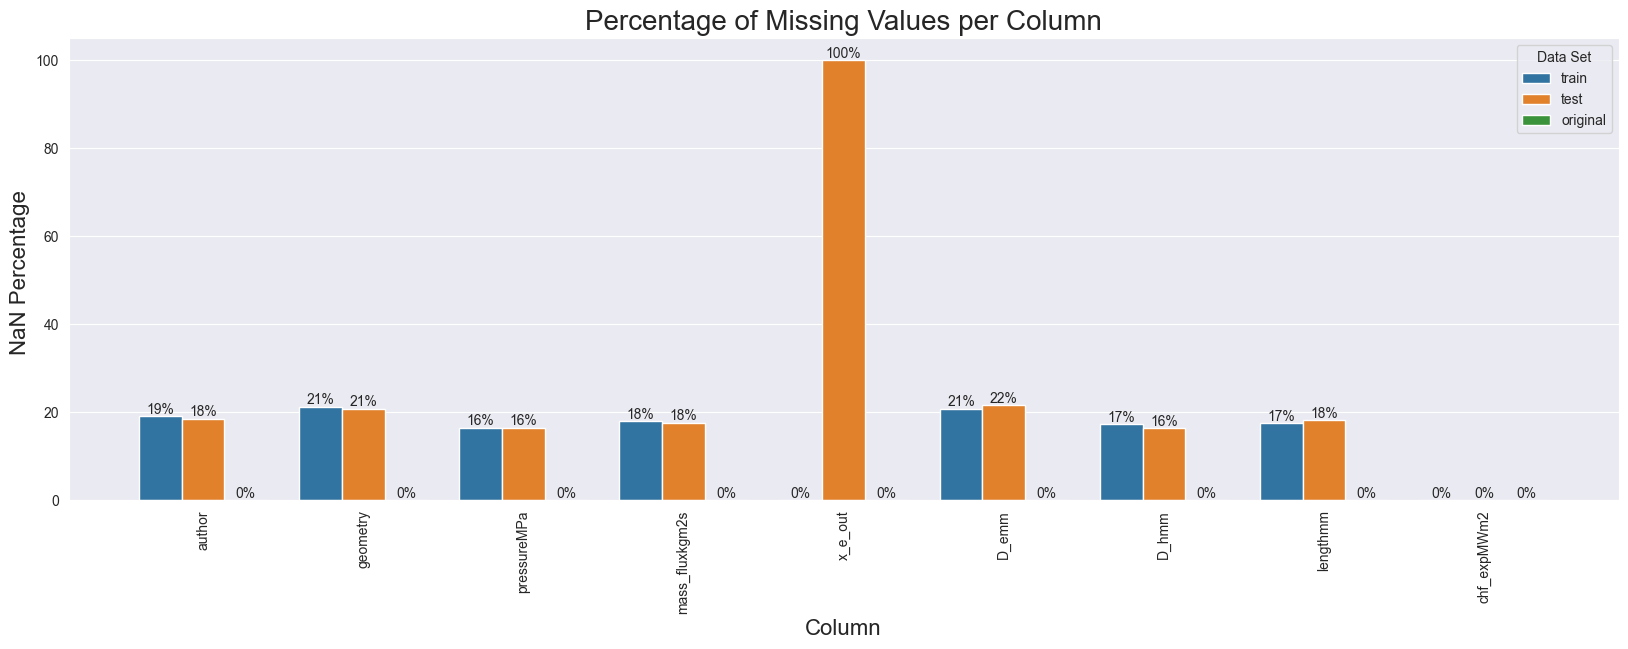

In [7]:
plt.figure(figsize=(20, 6))
ax = sns.barplot(data=df_tmp, y='NaN Percentage %', x="Column", hue="Data Set", orient='v')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f') + '%',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 5),
                textcoords = 'offset points')
plt.xlabel('Column', fontsize=16)
plt.ylabel('NaN Percentage ', fontsize=16)
plt.title('Percentage of Missing Values per Column', fontsize=20)
plt.plot()

##### Our training data contains lots of missing values, we could impute them using a very simple strategy like mean or median however this will likely result is poor model quality due to the about of missing value. Instead, we can also predict what value the missing value should have based off the other non-null value in these columns.

In [8]:
df_sample_submission.head()

,id,x_e_out [-]
0,4,0.0
1,7,0.0
2,10,0.0
3,12,0.0
4,23,0.0


##### As describe in the completions we are prediction the missing values for x_e_out, our test data consist of all the row with missing x_e_out.

In [9]:
df_data.head()

,author,geometry,pressureMPa,mass_fluxkgm2s,x_e_out,D_emm,D_hmm,lengthmm,chf_expMWm2
id,,,,,,,,,
0,Thompson,tube,7.00,3770.0,0.1754,NaN,10.8,432.0,3.6
1,Thompson,tube,NaN,6049.0,-0.0416,10.3,10.3,762.0,6.2
2,Thompson,NaN,13.79,2034.0,0.0335,7.7,7.7,457.0,2.5
3,Beus,annulus,13.79,3679.0,-0.0279,5.6,15.2,2134.0,3.0
4,NaN,tube,13.79,686.0,NaN,11.1,11.1,457.0,2.8


In [10]:
df_og.head()

,author,geometry,pressureMPa,mass_fluxkgm2s,x_e_out,D_emm,D_hmm,lengthmm,chf_expMWm2
id,,,,,,,,,
1,Inasaka,tube,0.39,5600,-0.1041,3.0,3.0,100,11.3
2,Inasaka,tube,0.31,6700,-0.0596,3.0,3.0,100,10.6
3,Inasaka,tube,0.33,4300,-0.0395,3.0,3.0,100,7.3
4,Inasaka,tube,0.62,6400,-0.1460,3.0,3.0,100,12.8
5,Inasaka,tube,0.64,4700,-0.0849,3.0,3.0,100,11.0


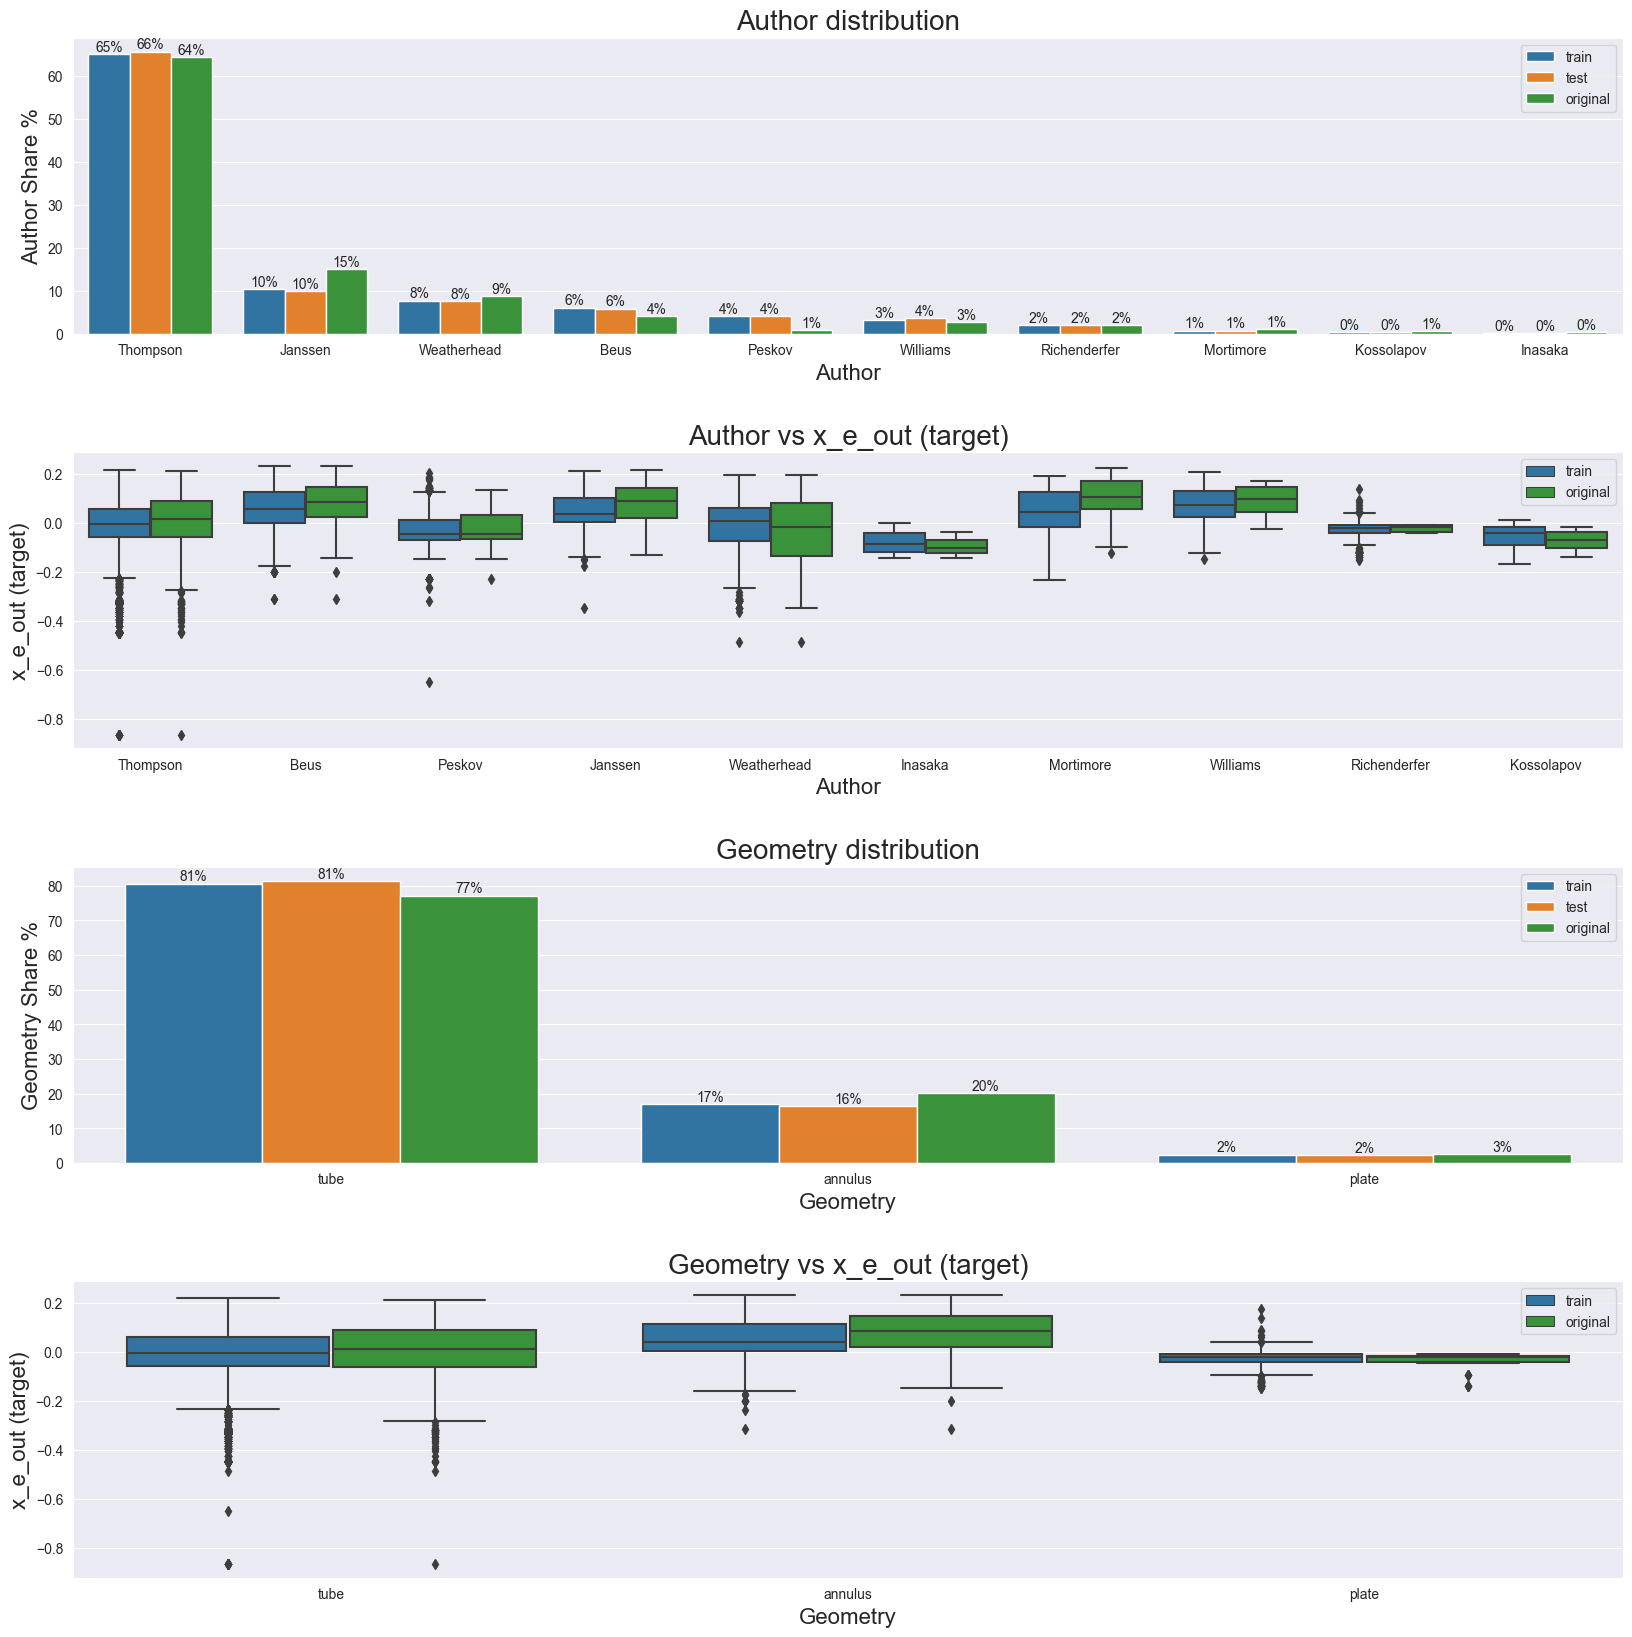

In [11]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(20, 20))
fig.subplots_adjust(hspace=0.4, wspace=0.3)
axes = axes.flatten()

def graph_categorical_feature(data: list[tuple[pd.DataFrame, str, str]], target: str, axes_start_i: int,
                              x_label: list[str] = ('x', 'x'), y_label: list[str] = ('y', 'y'), title: list[str]=None, colors: list[str] = None) -> None:

    # Plot barplots
    df_tmp = pd.DataFrame({})
    for df, column, label in data:
        df_tmp_local = pd.DataFrame(df[column].value_counts() * 100 / df[column].count())
        df_tmp_local['dataset'] = label
        df_tmp = pd.concat([df_tmp, df_tmp_local], axis=0)
    df_tmp['x'] = df_tmp.index
    df_tmp = df_tmp.rename(columns={column: 'y', 'dataset': 'Data Set'})
    sns.barplot(data=df_tmp, y='y', x="x", hue="Data Set", orient='v', ax=axes[axes_start_i])
    #axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90)
    for p in axes[i].patches:
        axes[i].annotate(format(p.get_height(), '.0f') + '%',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha = 'center', va = 'center',
                    xytext = (0, 5),
                    textcoords = 'offset points')
    axes[axes_start_i].set_xlabel(x_label[0], fontsize=16)
    axes[axes_start_i].set_ylabel(y_label[0], fontsize=16)
    if title is not None:
        axes[axes_start_i].set_title(title[0], fontsize=20)

    df_tmp = pd.DataFrame({})
    for df, column, label in data:
        if label != 'test':
            df_tmp_local = df.loc[:, [column, target]]
            df_tmp_local['dataset'] = label
            df_tmp = pd.concat([df_tmp, df_tmp_local], axis=0)
    df_tmp = df_tmp.rename(columns={column: 'c', 'dataset': 'Data Set'})
    if colors is not None:
        sns.boxplot(x='c', y=target, data=df_tmp, orient='v', hue="Data Set", ax=axes[axes_start_i + 1], palette=colors)
    else:
        sns.boxplot(x='c', y=target, data=df_tmp, orient='v', hue="Data Set", ax=axes[axes_start_i + 1])
    axes[axes_start_i + 1].set_xlabel(x_label[1], fontsize=16)
    axes[axes_start_i + 1].set_ylabel(y_label[1], fontsize=16)
    if title is not None:
        axes[axes_start_i + 1].set_title(title[1], fontsize=20)

    # Plot legends
    axes[axes_start_i].legend()
    axes[axes_start_i + 1].legend()

i = 0
graph_categorical_feature([(df_train, 'author', 'train'), (df_test, 'author', 'test'), (df_og, 'author', 'original')], 'x_e_out', i, x_label=['Author', 'Author'], y_label=['Author Share %', 'x_e_out (target)'], title=['Author distribution', 'Author vs x_e_out (target)'], colors=[sns.color_palette("tab10")[0], sns.color_palette("tab10")[2]])
i += 2
graph_categorical_feature([(df_train, 'geometry', 'train'), (df_test, 'geometry', 'test'), (df_og, 'geometry', 'original')], 'x_e_out', i, x_label=['Geometry', 'Geometry'], y_label=['Geometry Share %', 'x_e_out (target)'], title=['Geometry distribution', 'Geometry vs x_e_out (target)'], colors=[sns.color_palette("tab10")[0], sns.color_palette("tab10")[2]])
plt.show()

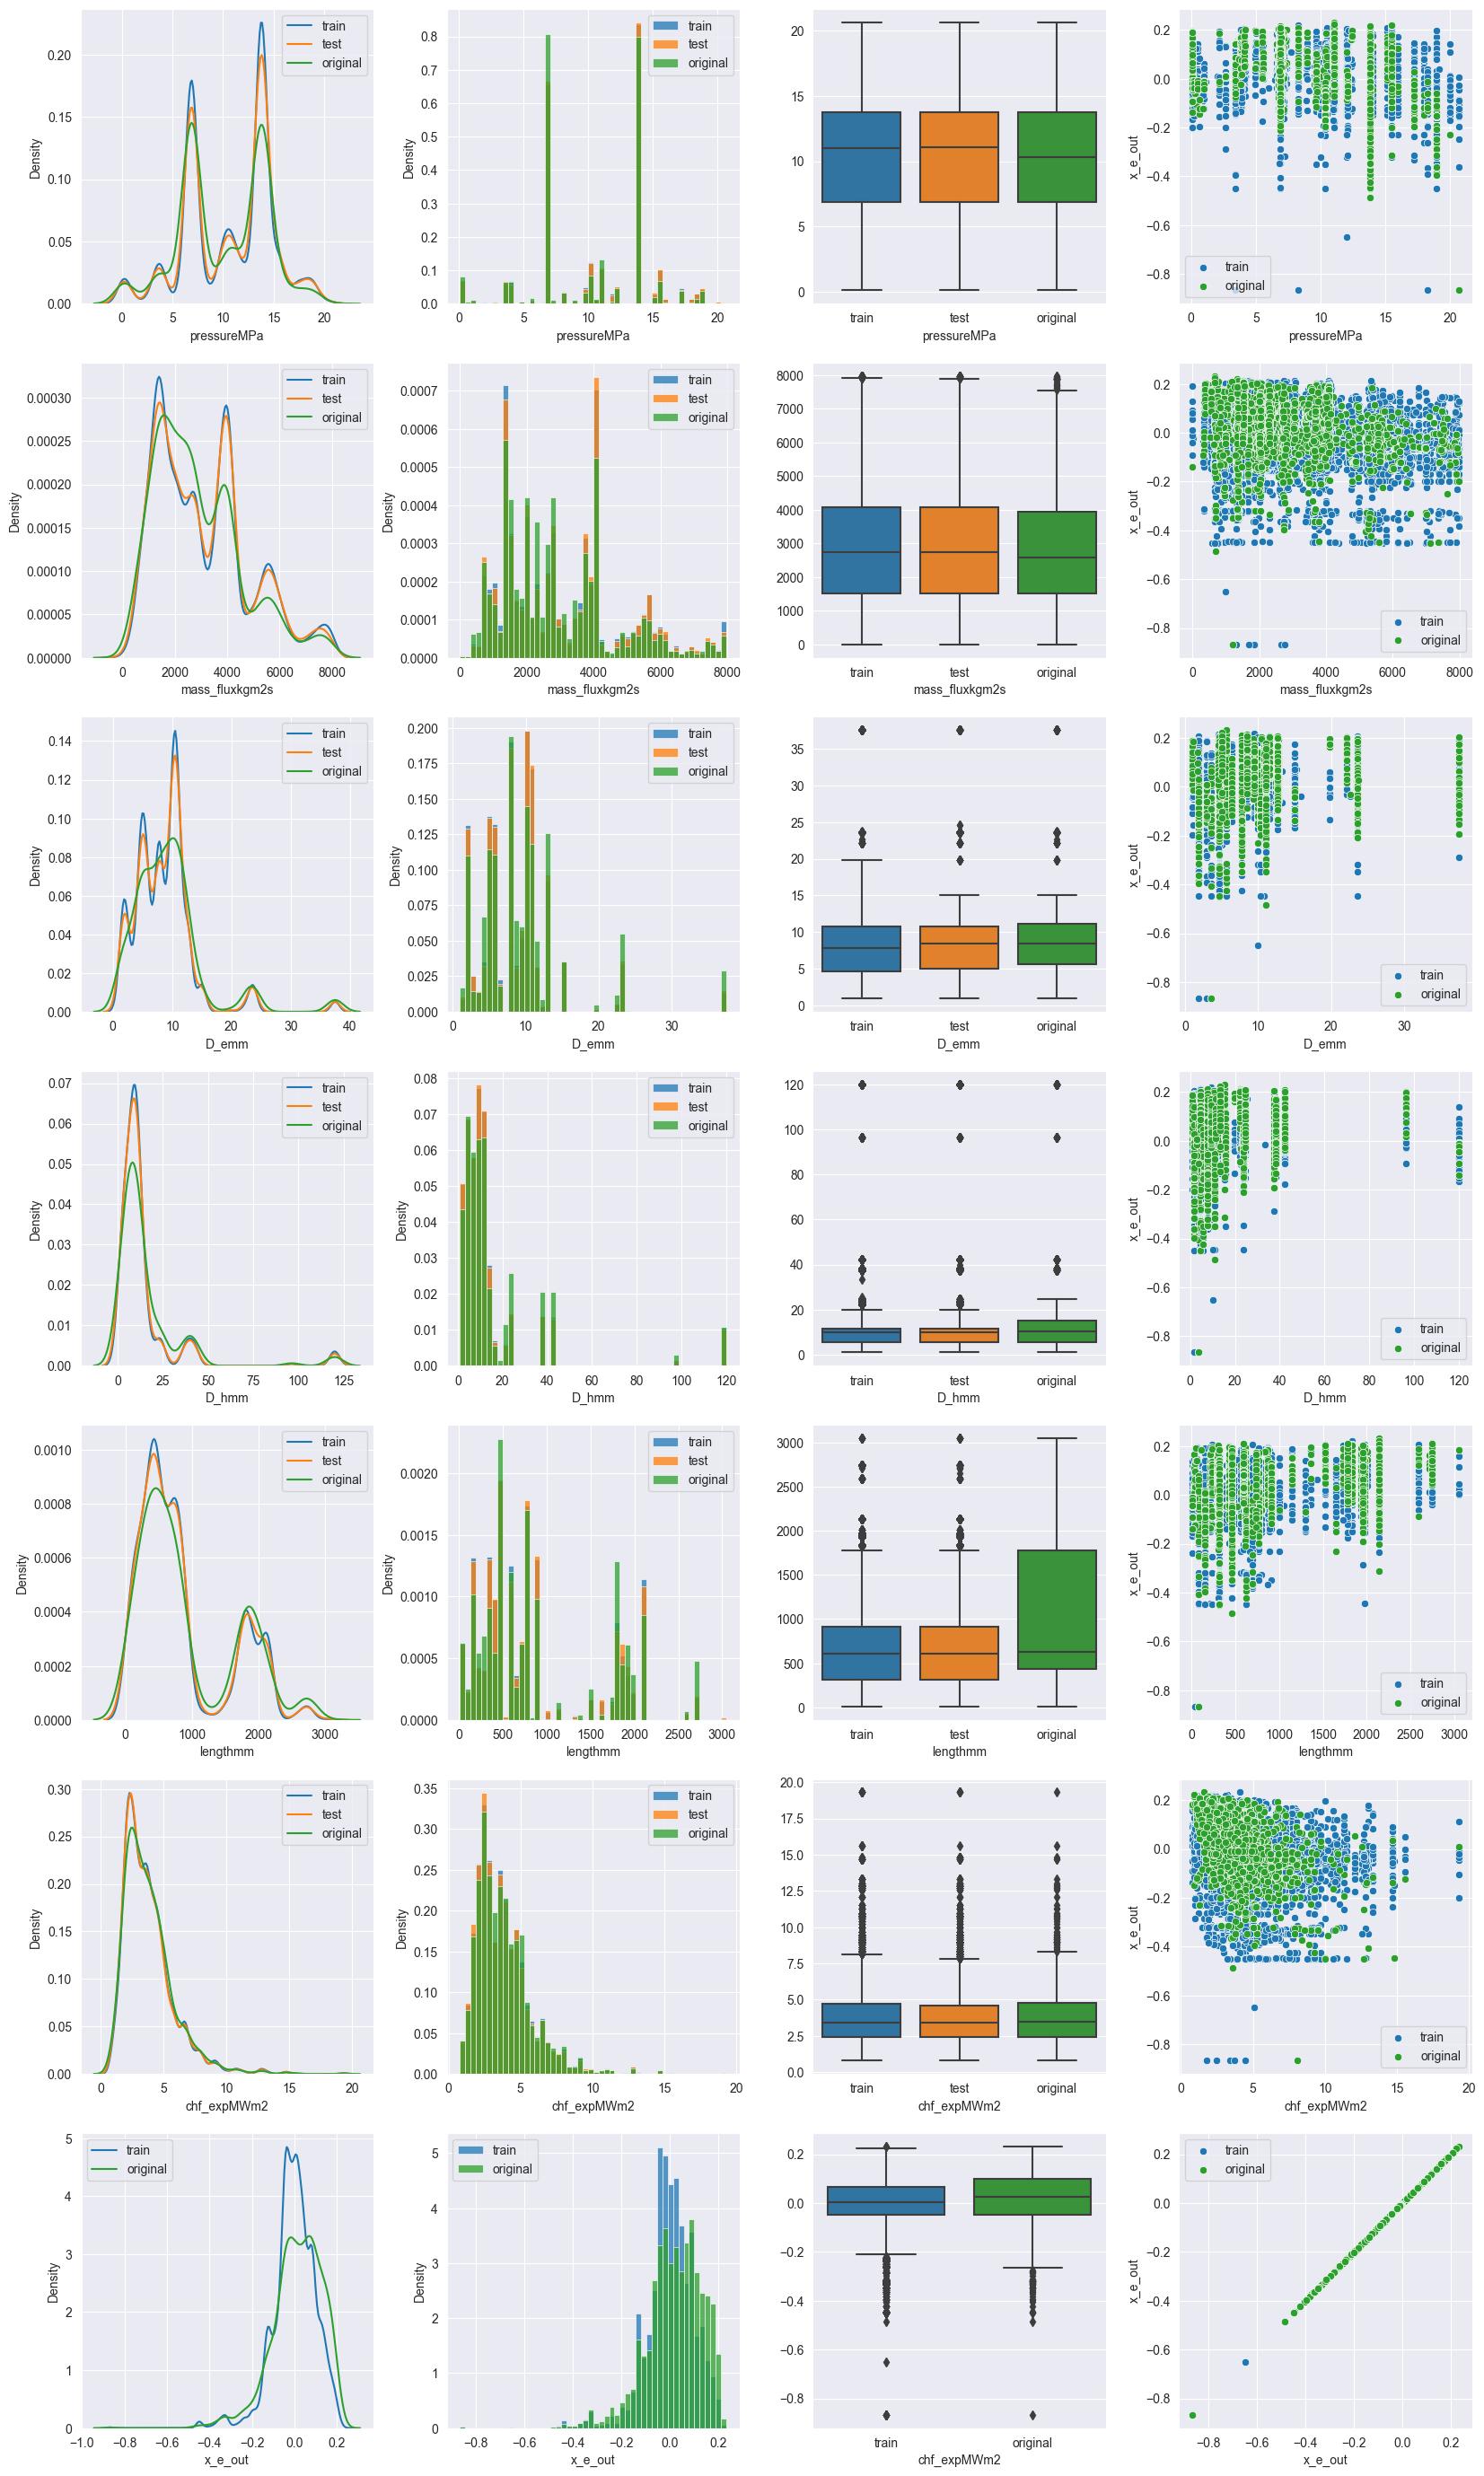

In [23]:
fig, axes = plt.subplots(nrows=len(df_data.columns) - 2, ncols=4, figsize=(20, 35))
fig.subplots_adjust(hspace=0.2, wspace=0.25)
axes = axes.flatten()

def graph_numerical_feature(data: list[tuple[pd.DataFrame, str, str]], target: str, axes_start_i: int, palette=sns.color_palette("tab10")) -> None:
    # Plot densities
    for e, cd in enumerate(data):
        df, column, label = cd
        sns.kdeplot(df[column], label=label, ax=axes[axes_start_i], fill=False, color=palette[e])
    for e, cd in enumerate(data):
        df, column, label = cd
        sns.histplot(df[column], label=label, ax=axes[axes_start_i + 1], stat="density", bins=50, color=palette[e])

    # Plot boxplot
    tmp_data_dict = {}
    for df, column, label in data:
        tmp_data_dict[label] = df[column]
    df_tmp = pd.DataFrame(tmp_data_dict)
    sns.boxplot(data=df_tmp, ax=axes[axes_start_i + 2], palette=palette)
    axes[axes_start_i + 2].set_xlabel(col)

    # Plot target correlation
    for e, cd in enumerate(data):
        df, column, label = cd
        if column != 'test':
            sns.scatterplot(x=column, y=target, label=label, ax=axes[axes_start_i + 3], data=df, color=palette[e])

    # Plot legends
    axes[axes_start_i].legend()
    axes[axes_start_i + 1].legend()
    axes[axes_start_i + 3].legend()

i = 0
for col in df_data.columns:
    if pd.api.types.is_numeric_dtype(df_data[col]):
        if col != 'x_e_out':
            graph_numerical_feature([(df_train, col, 'train'), (df_test, col, 'test'), (df_og, col, 'original')], 'x_e_out', i)
            i += 4
graph_numerical_feature([(df_train, 'x_e_out', 'train'), (df_og, 'x_e_out', 'original')], 'x_e_out', i, palette=[sns.color_palette("tab10")[0], sns.color_palette("tab10")[2]])
plt.show()

##### The original data closely follows the distribution of our given synthetic data. This suggesting the value where nulled in our given data set evenly across all features, this means that original data should be good to use without introduction feature or distribution bias.

In [ ]:
def show_feature_correlation(df: pd.DataFrame, title: str):
    plt.figure(figsize=(15, 15))
    corr_matrix = df.select_dtypes(include='number').corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr_matrix, dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, mask=mask)
    plt.title(title)
    plt.show()

show_feature_correlation(df_data, "Given")
show_feature_correlation(df_og, "Original")

# Data Prep

In [ ]:
numerical_columns = ['pressure [MPa]', 'mass_flux [kg/m2-s]','x_e_out [-]', 'D_e [mm]', 'D_h [mm]', 'length [mm]', 'chf_exp [MW/m2]']
numerical_features = ['pressure [MPa]', 'mass_flux [kg/m2-s]', 'D_e [mm]', 'D_h [mm]', 'length [mm]', 'chf_exp [MW/m2]']
categorical_columns = ['author', 'geometry']
target = 'x_e_out [-]'

In [ ]:
label_encoders = {}

def label_encode(df: pd.DataFrame) -> None:
    for column in categorical_columns:
        label_encoder: LabelEncoder = LabelEncoder()
        df[column] = label_encoder.fit_transform(df[column])
        label_encoders[column] = label_encoder

def reverse_encode(df: pd.DataFrame) -> None:
    for column in label_encoders.keys():
        df[column] = df[column].astype(int)
        df[column] = label_encoders[column].inverse_transform(df[column])

def one_hot_encode(df: pd.DataFrame) -> pd.DataFrame:
    one_hot_encoded_data = pd.get_dummies(df, columns=categorical_columns)
    return one_hot_encoded_data

def normalize(df: pd.DataFrame) -> pd.DataFrame:
    for column in numerical_features:
        column_values = df[column].values  # No need to reshape column values
        not_nan_values = column_values[~pd.isnull(column_values)]  # Filter non-NaN values

        if not_nan_values.size > 0:  # Check if there are any non-NaN values
            not_nan_values = not_nan_values.reshape(-1, 1)  # Reshape to 2D array with single column
            standard_scaler = StandardScaler()
            normalized_values = standard_scaler.fit_transform(not_nan_values)

            # Create a mask to identify non-NaN values in the column
            mask = ~pd.isnull(df[column])
            # Replace the non-NaN values with normalized values in the original DataFrame
            df.loc[mask, column] = normalized_values.flatten()

    return df

In [ ]:
df_train: pd.DataFrame = pd.concat([df_data, df_og])
df_train.reset_index(inplace=True, drop=True)

In [ ]:
normalize(df_train)

In [ ]:
#label_encode(df_train)

In [ ]:
df_train = one_hot_encode(df_train)

In [ ]:
df_train

# Train

## Impute missing numerical features

In [ ]:
# Create an instance of imputer
#imputer = IterativeSVD()
imputer = KNN()

# Perform the imputation
df_train_imputed = pd.DataFrame(imputer.fit_transform(df_train), columns=df_train.columns)
# Print the imputed DataFrame
print("Imputed DataFrame:")
df_train_imputed

In [ ]:
df_train_imputed.isna().sum()

## Train tree boosting models

### Construct new training data

In [ ]:
for column in numerical_features:
    if df_train[column].isna().sum() > 0:
        df_train[f'{column}_was_an'] = df_train[column].isna().astype(int)

In [ ]:
for column in numerical_features:
    if df_train[column].isna().sum() > 0:
        df_train[column] = df_train_imputed[column]

In [ ]:
df_test = df_train[df_train[target].isna()]
df_train = df_train[~df_train[target].isna()]

In [ ]:


#df_test = remove_special_characters_from_dataframe(df_test)
#df_train = remove_special_characters_from_dataframe(df_train)

#df_train = df_train[['mass_fluxkgm2s', 'pressureMPa', 'lengthmm', 'D_emm', 'D_hmm', 'chf_expMWm2', 'geometry_tube', 'x_e_out']]
#df_test = df_test[['mass_fluxkgm2s', 'pressureMPa', 'lengthmm', 'D_emm', 'D_hmm', 'chf_expMWm2', 'geometry_tube', 'x_e_out']]

In [ ]:
def objective(trial):
    # Define the hyperparameter search space
    params = {
        'metric': 'mse',
        'n_estimators': trial.suggest_int('n_estimators', 500, 5000),
        'max_depth': trial.suggest_int('max_depth', 4, 8),
        'num_leaves': trial.suggest_int('num_leaves', 3, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 20),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'force_col_wise': trial.suggest_categorical('force_col_wise', [True, False]),
        'verbosity': -1
    }

    # Split the data into training and validation sets
    X = df_train.drop('x_e_out', axis=1)
    y = df_train['x_e_out']
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the LGBM regressor
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)

    # Predict on the validation set and calculate MAE
    y_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)

    return mae

# Create the Optuna study
study_lgbm = optuna.create_study(direction='minimize')

# Start the hyperparameter search
study_lgbm.optimize(objective, n_trials=100)

# Print the best parameters and the best MAE
best_params = study_lgbm.best_params
best_mae = study_lgbm.best_value
print(f"Best Parameters: {best_params}")
print(f"Best MAE: {best_mae}")

In [ ]:
def objective(trial):
    # Define the hyperparameter search space
    params = {
        'loss_function': 'MAE',
        'depth': trial.suggest_int('depth', 3, 16),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.2),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0, 1),
        'random_strength': trial.suggest_float('random_strength', 0, 1),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'iterations': trial.suggest_int('iterations', 500, 5000),
        'early_stopping_rounds': 100,
        'verbose': False
    }

    # Split the data into training and validation sets
    X = df_train.drop('x_e_out', axis=1)
    y = df_train['x_e_out']
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the CatBoost regressor
    model = CatBoostRegressor(**params)
    model.fit(X_train, y_train, eval_set=(X_val, y_val))

    # Predict on the validation set and calculate MAE
    y_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)

    return mae

# Create the Optuna study
study_catboost = optuna.create_study(direction='minimize')

# Start the hyperparameter search
study_catboost.optimize(objective, n_trials=100)

# Print the best parameters and the best MAE
best_params = study_catboost.best_params
best_mae = study_catboost.best_value
print(f"Best Parameters: {best_params}")
print(f"Best MAE: {best_mae}")

In [ ]:
def objective(trial):
    # Define the hyperparameter search space
    params = {
        'objective': 'reg:pseudohubererror',
        'eval_metric': 'mae',
        'n_estimators': trial.suggest_int('n_estimators', 500, 5000),
        'max_depth': trial.suggest_int('max_depth', 3, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'min_child_weight': trial.suggest_float('min_child_weight', 0.1, 10.0),
        'gamma': trial.suggest_float('gamma', 0.0, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        #'grow_policy': 'lossguide',
        'eta': trial.suggest_float('eta', 0.00, 1),
        'early_stopping_rounds': 100,
        'huber_slope': trial.suggest_float('huber_slope', 0.01, 0.5),
        'verbosity': 0
    }

    # Split the data into training and validation sets
    X = df_train.drop('x_e_out', axis=1)
    y = df_train['x_e_out']
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the XGBoost regressor
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    model = xgb.train(params, dtrain, evals=[(dval, 'validation')], verbose_eval=False)

    # Predict on the validation set and calculate MAE
    y_pred = model.predict(dval)
    mae = mean_absolute_error(y_val, y_pred)

    return mae

# Create the Optuna study
study_xgboost = optuna.create_study(direction='minimize')

# Start the hyperparameter search
study_xgboost.optimize(objective, n_trials=250)

# Print the best parameters and the best MAE
best_params = study_xgboost.best_params
best_mae = study_xgboost.best_value
print(f"Best Parameters: {best_params}")
print(f"Best MAE: {best_mae}")

In [ ]:
class Pipeline:

    def __init__(self, model_type: str):
        self.model_type = model_type
        if model_type == 'LightGBM':
            self.model = lgb.LGBMRegressor(**study_lgbm.best_params)
        elif model_type == 'CatBoost':
            self.model = CatBoostRegressor(**study_catboost.best_params)
        elif model_type == 'XGBoost':
            self.model = xgb.XGBRegressor(**study_xgboost.best_params)
        else:
            raise ValueError(f"Given model type is not supported! {model_type} was given.")

    def fit(self, X, y, X_val, y_val):
        if self.model_type in ['CatBoost']:
            self.model.fit(X, y.ravel(), eval_set=[(X_val, y_val.ravel())], early_stopping_rounds=100, verbose=False)
        else:
            self.model.fit(X, y.ravel(), eval_set=[(X_val, y_val.ravel())], verbose=False)

    def predict(self, X):
        return self.model.predict(X)

In [ ]:
def train(model_type):
    X = df_train.drop(['x_e_out'], axis=1)
    y = df_train['x_e_out']
    SKFs = KFold(n_splits=10, shuffle=True, random_state=1)
    losses = []
    pipelines = []
    idx_vls = []
    for fold, (idx_tr, idx_vl) in enumerate(SKFs.split(X, y)):
        train_dataframe = df_train.iloc[idx_tr]
        dev_dataframe = df_train.iloc[idx_vl]

        # splits data to features and target
        X_train = train_dataframe.drop('x_e_out', axis=1)
        y_train = train_dataframe['x_e_out']
        X_dev = dev_dataframe.drop('x_e_out', axis=1)
        y_dev = dev_dataframe['x_e_out']

        # crates and fits a pipeline
        pipelineMy = Pipeline(model_type)
        pipelineMy.fit(X_train, y_train, X_dev, y_dev)

        # evaluates the model
        pipelines.append(pipelineMy)
        loss = mean_absolute_error(y_dev, pipelineMy.predict(X_dev))
        losses.append(loss)
        idx_vls.append(idx_vl)
        print(f'Fold {fold} loss: {loss}')
    print(f'Mean loss: {np.array(losses).mean()}')
    return losses, pipelines, idx_vls

In [ ]:
supported_models = ['LightGBM', 'CatBoost', 'XGBoost']

In [ ]:
train_results = {}
for model_name in supported_models:
    print(f"-------------------- {model_name} -------------------- ")
    losses, pipelines, eval_sets = train(model_name)
    train_results[f'{model_name}_losses'] = losses
    train_results[f'{model_name}_pipelines'] = pipelines
    train_results[f'{model_name}_eval_sets'] = eval_sets

## Calculate assembly weights

In [ ]:
model_predictions_on_validation = {'model_name': [], 'x': [], 'y': []}
def calc_model_predictions_on_validation(pipelines, eval_sets_idx):
    predictions = None
    ground_truth = None

    for pipeline, eval_set in zip(pipelines, eval_sets_idx):
        dev = df_train.iloc[eval_set[eval_set < 15281]]
        X_dev = dev.drop('x_e_out', axis=1)
        y_dev = dev['x_e_out']
        prediction = pipeline.predict(X_dev)

        if predictions is None:
            predictions = np.array(prediction).flatten()
            ground_truth = np.array(y_dev).flatten()
        else:
            predictions = np.concatenate((predictions,  np.array(prediction).flatten()))
            ground_truth = np.concatenate((ground_truth,  np.array(y_dev).flatten()))

    model_predictions_on_validation['model_name'].append(model_name)
    model_predictions_on_validation['x'].append(predictions)
    model_predictions_on_validation['y'].append(ground_truth) # Should be the same for all models

for model_name in supported_models:
    calc_model_predictions_on_validation(train_results[f'{model_name}_pipelines'], train_results[f'{model_name}_eval_sets'])

In [ ]:
def eval_assembly_on_validation(weights):
    #weights = weights / np.sum(weights, axis=0, keepdims=True)
    prediction = 0

    for model_id, x in enumerate(model_predictions_on_validation['x']):
        prediction += x * weights[model_id]

    return mean_absolute_error(model_predictions_on_validation['y'][0], prediction)

In [ ]:
# Set initial weights
model_weights = np.array([0.1, 0.8, 0.1])
# Define the optimization bounds
bounds = [(0, 1.0)] * len(model_weights)

# Define the optimization function
res = minimize(eval_assembly_on_validation, model_weights, method='nelder-mead', bounds=bounds)
# Print the optimized weights
optimal_model_weights = res.x
print(optimal_model_weights.sum())
optimal_model_weights = optimal_model_weights / np.sum(optimal_model_weights, axis=0, keepdims=True)
print(optimal_model_weights.sum())
optimal_model_weights = np.array([0.1, 0.8, 0.1])

In [ ]:
df_optimal_model_weights = {'model_name': [], 'weight': []}
for i in range(len(model_predictions_on_validation['model_name'])):
    df_optimal_model_weights['model_name'].append(model_predictions_on_validation['model_name'][i])
    df_optimal_model_weights['weight'].append(optimal_model_weights[i])
    print(f"{optimal_model_weights[i]:.3f} {model_predictions_on_validation['model_name'][i]}")
df_optimal_model_weights = pd.DataFrame(df_optimal_model_weights)

In [ ]:
performance_data = {'model_name': [], 'training_loss': [], 'og_data_excluded': []}
def get_loss(pipelines, eval_sets_idx):
    losses = []

    for pipeline, eval_set in zip(pipelines, eval_sets_idx):
        dev = df_train.iloc[eval_set[eval_set < 15281]]
        X_dev = dev.drop('x_e_out', axis=1)
        y_dev = dev['x_e_out']
        prediction = pipeline.predict(X_dev)

        loss = mean_absolute_error(y_dev, prediction)
        losses.append(loss)

    return np.array(losses).mean()

for model_name in supported_models:
    performance_data['model_name'].append(model_name)
    performance_data['training_loss'].append(np.array(train_results[f'{model_name}_losses']).mean())
    performance_data['og_data_excluded'].append(get_loss(train_results[f'{model_name}_pipelines'], train_results[f'{model_name}_eval_sets']))
performance_data = pd.DataFrame(performance_data)

In [ ]:
loss_eval_types: list[str] = ['training_loss', 'og_data_excluded']
fig, axes = plt.subplots(nrows=len(loss_eval_types), ncols=1, figsize=(6, 10))
axes = axes.flatten()

palette = sns.color_palette("husl", n_colors=len(performance_data))
palette_reversed = palette[::-1]
titles = ['Model performance on validation (training data + original data)',
          'Model performance on validation (training data only)']

for ax_index, loss_eval_type in enumerate(loss_eval_types):
    performance_data.sort_values(loss_eval_type, ascending=True, inplace=True)
    sns.barplot(x=loss_eval_type, y='model_name', data=performance_data, ax=axes[ax_index], palette=palette_reversed)
    for i, v in enumerate(performance_data[loss_eval_type]):
        axes[ax_index].text(v - 0.03, i, '{:.3f}'.format(v), color='black', fontweight='bold', ha='right', va='center')
    axes[ax_index].set(ylabel=None)
    axes[ax_index].set(xlabel="Mean MAE over 10 K-Folds")
    axes[ax_index].set_title(titles[ax_index])
plt.show()

In [ ]:
performance_data

In [ ]:
df_optimal_model_weights.sort_values('weight', ascending=True, inplace=True)
ax = sns.barplot(x='weight', y='model_name', data=df_optimal_model_weights)
ax.set_ylim(ax.get_ylim()[::-1])
for i, v in enumerate(df_optimal_model_weights['weight']):
    ax.text(v - 0.03, i, '{:.3f}'.format(v), color='black', fontweight='bold', ha='right', va='center')
ax.set(ylabel=None)
ax.set(xlabel="Normalized model ensemble weights")
ax.set_xlim([-0.1, None])
ax.set_xticks([-0.1, 0, 0.1, 0.2, 0.3, 0.4])
ax.set_xticklabels(['', 0, 0.1, 0.2, 0.3, 0.4])
plt.axvline(x=0, color='g', linestyle='-')
plt.show()

# Feature Importance

In [ ]:
def make_predictions(x):
    prediction = 0

    for model_id in range(len(supported_models)):
        for pipeline in train_results[f'{supported_models[model_id]}_pipelines']:
            prediction += np.array(pipeline.predict(x)).flatten() * optimal_model_weights[model_id]
    prediction = prediction / 10.0
    #model_name_to_use = 'XGBoost'
    #for pipeline in train_results[f'{model_name_to_use}_pipelines']:
    #    prediction += np.array(pipeline.predict(x)).flatten()
    #prediction = prediction / float(len(train_results[f'{model_name_to_use}_pipelines']))

    return prediction

In [ ]:
# Get feature importance
importance = train_results['LightGBM_pipelines'][0].model.feature_importances_
for i in range(1, len(train_results['LightGBM_pipelines'])):
    importance += train_results['LightGBM_pipelines'][i].model.feature_importances_
importance = importance / 5.0
feature_names = df_train.drop('x_e_out', axis=1).columns.values

# Create a dataframe of feature importance
df_importance = pd.DataFrame({'feature': feature_names, 'importance': importance})
# Sort features by importance
df_importance = df_importance.sort_values('importance', ascending=False)

# Create horizontal bar plot of feature importance
sns.set_style("whitegrid")
plt.figure(figsize=(10, 8))
palette = sns.color_palette("husl", len(df_importance))
palette.reverse()
sns.barplot(x="importance", y="feature", data=df_importance, palette=palette)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [ ]:
def get_split_data(eval_sets_idx) -> tuple[pd.DataFrame, pd.DataFrame]:
    df_all_data: pd.DataFrame = None
    for eval_set in eval_sets_idx:
        if df_all_data is None:
            df_all_data = df_train.iloc[eval_set]
        else:
            df_all_data = pd.concat([df_all_data, df_train.iloc[eval_set]])

    df_eval_given: pd.DataFrame = df_all_data[df_all_data.index < len(df_data)]
    df_eval_original: pd.DataFrame = df_all_data[df_all_data.index >= len(df_data)]

    return df_eval_given, df_eval_original

In [ ]:
def graph_predictions_vs_true() -> None:
    # All model should have the exact same eval sets
    df_eval_given, df_eval_original = get_split_data(train_results['LightGBM_eval_sets'])

    graph_data = {
        "data": [df_eval_given, df_eval_original],
        "name": ['given', 'original']
    }

    for data, name in zip(graph_data['data'], graph_data['name']):
        X = data.drop('x_e_out', axis=1)
        y = data['x_e_out']
        y_predicted = make_predictions(X)
        data_to_graph = pd.DataFrame({"Predicted": y_predicted, "True": y})
        sns.scatterplot(x='Predicted', y='True', label=f"Belong to {name}", data=data_to_graph)

    plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, ls='--', c='red')
    plt.title("True vs Predicted")
    plt.legend()

In [ ]:
graph_predictions_vs_true()

# Make predictions

In [ ]:
df_test = df_test.drop('x_e_out', axis=1)

In [ ]:
predictions = make_predictions(df_test)

In [ ]:
df_test['x_e_out [-]'] = predictions

In [ ]:
df_test['x_e_out [-]'].to_csv("submission.csv", index=True, index_label='id')